# Hyperparameter Tuning Methods Comparison
Cross validation approach based on the following [repo](https://github.com/roamanalytics/roamresearch/tree/master/BlogPosts/Hyperparameter_tuning_comparison)

In [24]:
%matplotlib inline

In [25]:
import dataset_loader as datasets
import seaborn as sns
from hpt_cmp import *
from model_loader import *

In [26]:
%load_ext autoreload
%aimport hpt_cmp
%aimport dataset_loader
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
from __future__ import print_function
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from hyperopt import 

In [93]:
# Loading the Digits dataset
mth = 'load_'+'digits'
digits = datasets.load_digits()
iris = datasets.load_iris()
wine = datasets.load_wine()
bc = datasets.load_breast_cancer()
cs = datasets.load_census_50k()

dataset = cs
# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_features = dataset.data.shape[1]


In [94]:
# x = 1
# while x < n_features:
#     max_f.append(x)
#     x +=x
# max_f.append(n_features)

In [95]:
max_f = ['auto', 'sqrt', 'log2']
seed = np.array([1], dtype=np.integer)
n_features = dataset.data.shape[1]
param_grid = {
        "max_depth": [3, None],
        "max_features": max_f,
        #"min_samples_split": [5, 10, 20],
        "bootstrap": [True, False],
        #"criterion": ["gini", "entropy"],
        'random_state':seed
}

hyperopt_grid = {
        "max_depth": hp.choice("max_depth",[3, None]),
        "max_features": hp.choice("max_features",max_f),
        #"min_samples_split": hp.loguniform("min_samples_split",np.log(5), np.log(20)),
        "bootstrap": hp.choice("bootstrap",[True, False]),
        #"criterion": hp.choice("criterion",["gini", "entropy"]),
        'random_state':seed[0]
}

bayes_grid = {
        "max_depth": Categorical([3, None]),
        "max_features": Categorical(max_f),
        #"min_samples_split": Real(5, 20, 'loguniform'),
        "bootstrap": Categorical([True, False]),
        #"criterion": Categorical(["gini", "entropy"]),
        'random_state':seed
}

base = {
    'random_state':seed[0]
}

In [96]:
hpt_objs = [
    # add more objs once more search functions implemented
        ('Baseline', base, run_baseline, {}),
        #('BaysianSearch', bayes_grid,baysian_search,{'n_iter':MAX_ITER}),
        ('Tree of Parzen Estimator',hyperopt_grid,tpe_search,{}),
        ('RandomSearch', param_grid, random_search,{'n_iter':MAX_ITER}),
        ('GridSearch', param_grid, grid_search, {}),
]

#### cmp_hpt_methods
Parameter description
> `htp_objs`: list of hyperparam-tuning object <br>
> `model`: sklearn model to optimize (needs to have fit/predict function)<br>
> `dataset`: tuple of (X,y) e.g (Data, Target) <br>
> `loss`: sklearn loss function to user <br>
> `metric`: sklearn metric to optimize for <br>
> `datset_split`: random_state for datasetsplit <br>
> `name`: currently not user *optional* <br>

In [97]:
all_results = []

# Run search & print result
results = cmp_hpt_methods(
        (dataset.data, dataset.target),
        hpt_objs,
        RandomForestClassifier,
        'accuracy', #http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        accuracy_score, name='RandFor-digits')
all_results.append(results)

25 3


In [98]:
sum_res = []
for r in all_results[0]:
    sum_res.append((r[HPT_METHOD], r[CV_TIME],len(r[INNER_RES]['params']), r[TEST_ACC], r[BEST_PARAMS], np.array(r[INNER_RES]['mean_test_score']).mean() ))

df = pd.DataFrame(sum_res, columns=[HPT_METHOD, 'TIME', PARAMS_SAMPLED, TEST_ACC, BEST_PARAMS, 'SCORE'])

In [99]:
df

,HPT method,TIME,Parameters sampled,Test accuracy,Best Parameters,SCORE
0,Baseline,0.045332,1,0.884527,{'random_state': 1},0.918795
1,Tree of Parzen Estimator,0.887312,25,0.916859,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.900339
2,RandomSearch,0.437131,12,0.916859,"{'random_state': 1, 'max_features': 'log2', 'm...",0.894142
3,GridSearch,0.407971,12,0.916859,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.894142


In [100]:
pd.DataFrame(df[BEST_PARAMS].tolist())

,bootstrap,max_depth,max_features,random_state
0,NaN,NaN,NaN,1
1,True,NaN,log2,1
2,True,NaN,log2,1
3,True,NaN,log2,1


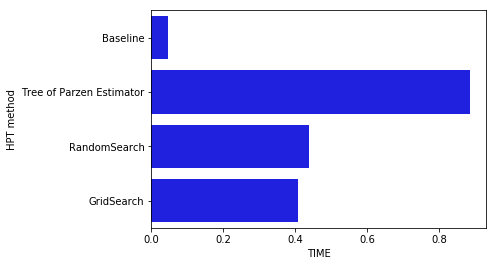

<Figure size 432x288 with 0 Axes>

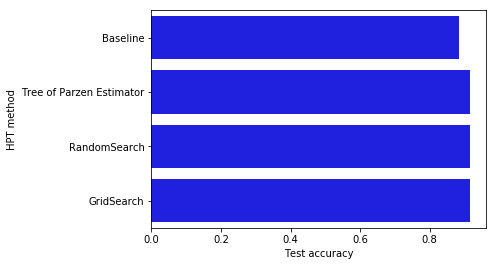

In [101]:
# plot comparison
plt.figure()
sns.barplot(x='TIME', y=HPT_METHOD,data =df, color='b')
plt.figure()
# plot accuracy comparison
fig, ax =plt.subplots()
#ax.set(xlim=(0.95, 1.0))
sns.barplot(x=TEST_ACC, y=HPT_METHOD, ax = ax,data =df, color='b')

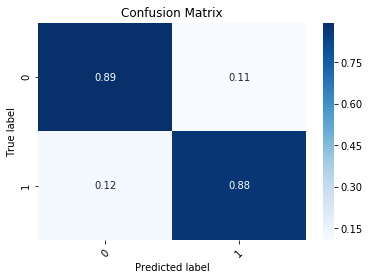

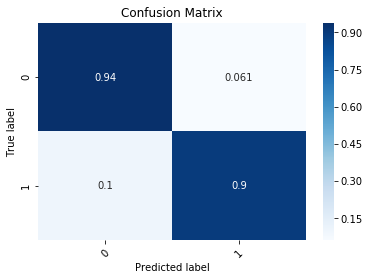

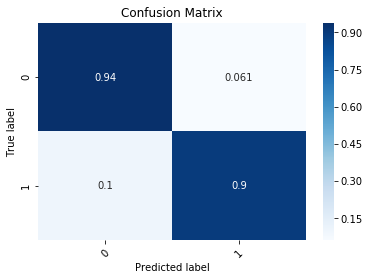

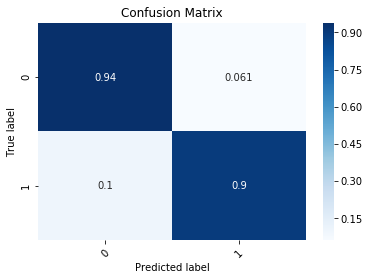

In [102]:
for r in all_results[0]:
    plot_confusion_matrix(r[CONF_MATRIX], digits.target_names)

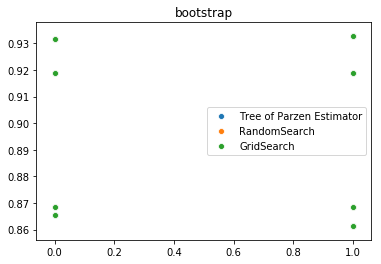

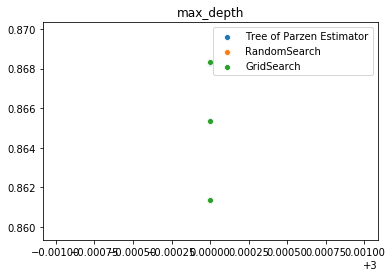

In [103]:
for param in ['bootstrap', 'max_depth']:
    fig, ax = plt.subplots()
    #ax.set_xscale('log')
    for r in all_results[0]:

        if r[HPT_METHOD]=='Baseline': continue
        ax = sns.scatterplot(x='param_'+param, y='mean_test_score', data=r[INNER_RES], label=r[HPT_METHOD])
        ax.set_title(param)

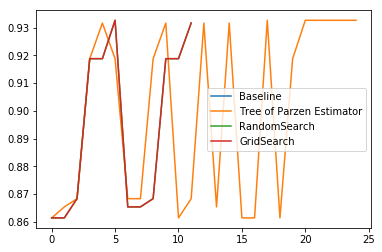

In [104]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
for r in all_results[0]:
    sns.lineplot(x=[i for i in range(r[PARAMS_SAMPLED])], y=r[INNER_RES]['mean_test_score'],label=r[HPT_METHOD])